*Name:* Jorge Eduardo Angarita Pérez

*Student Code:* 2248431

"_By Pedal_" implmentation of an ARX model for the Dryer2 model example for Matlab

First, some libraries are imported.

In [107]:
import numpy as np                          # General numerical data processing
import matplotlib.pyplot as plt             # Plots
import pandas as pd                         # CSV data management

### *Previous steps:*

Import dryer2 data

In [108]:
#ADC Architecture
CSV_dryer2 = 'dryer2.csv'
dryer2 = pd.read_csv(CSV_dryer2)
print(dryer2.keys())

Index(['Time', 'Input', 'Output'], dtype='object')


Print input and output vs time

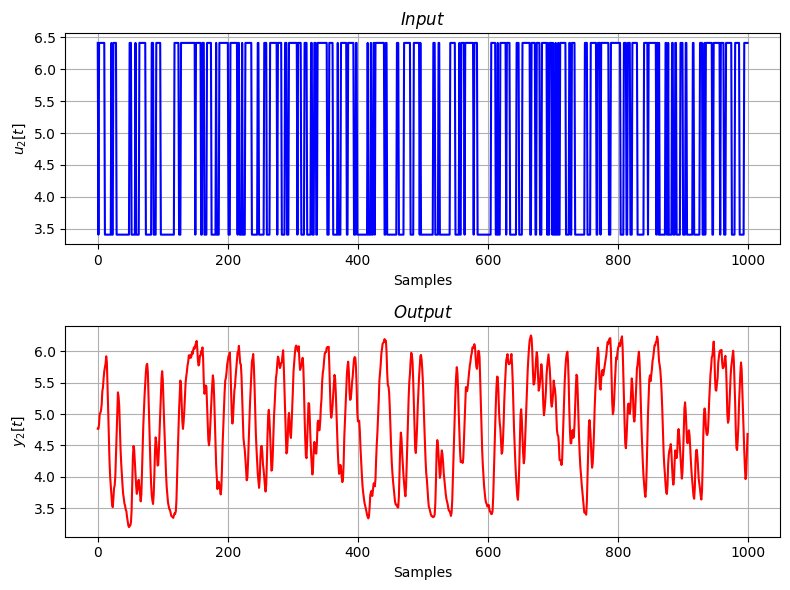

In [109]:
time = dryer2['Time'].to_numpy()
input = dryer2['Input'].to_numpy()
output = dryer2['Output'].to_numpy()

#  Top Figure
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))

# Input
axs[0].plot(time, input, color='b')
axs[0].set_title('$Input$')
axs[0].set_xlabel('Samples') 
axs[0].set_ylabel('$u_2[t]$') 
axs[0].grid(True)

# Output
axs[1].plot(time, output, color='r')
axs[1].set_title('$Output$')
axs[1].set_xlabel('Samples') 
axs[1].set_ylabel('$y_2[t]$') 
axs[1].grid(True)

plt.tight_layout()
plt.show()


Create a function to evaluate the model based in the differences equation:

In [110]:
def Out_Model(theta, na, nb, u, y):
    y_pred = np.zeros_like(u, dtype = float)

    # Number of samples
    t_tot = len(u)

    for t in range(1, t_tot):
        # Last "na" elements of y
        y_range = -y[max(t - na, 0): (t)]
        # Last "nb" elements of u
        u_range = u[max(t - nb, 0): (t)]

        # Obtain y_pred as in equation 4.12 of Ljung System Identification
        y_pred[t] = np.dot(theta[:len(y_range)], y_range) + np.dot(theta[na:na + len(u_range)], u_range)
    return y_pred

### *ARX Model estimation*

A vector of theta weights will be created:

In [111]:
na = 2
nb = 4
#theta = 0.5*np.ones(na + nb)
theta = np.random.rand(na + nb)

A cost function based on least squares is introduced:

In [112]:
# Mean square Error
def Cost(Weights, Out = output):
    Out_Pred = Out_Model(Weights, na, nb, input, Out)
    Fun_Cost = (Out - Out_Pred)**2
    return sum(Fun_Cost)/len(Fun_Cost)

Ini_Cost = Cost(theta)
print(f'Initial Cost: {Ini_Cost}')

Initial Cost: 13.506146098812946


### *Optimization functions*

To obtain the final model parameters, three different algorithms are introduced, they are Cyclic Coordinate, Leven Marquardt and BFGS. Some of the required functions are listed below, followed by the algorithm steps.

In [113]:
# Single-Variable Functions

def deriv(f, x, delta):
    y = (f(x + delta) - f(x)) / delta
    return y

def Second_Deriv(f, x, delta):
    y = (f(x + 2*delta) -2*f(x + delta) + f(x)) / delta**2
    return y

# Newton search for 1D

def Newton_Search(f, current, epsilon, delta):
    # Initialization (do While)
    Continue = True
    x = current
    while Continue:
        # First derivative
        deriv_current = deriv(f, x, delta)
        # Second derivative
        deriv2nd_current = Second_Deriv(f, x, delta)
        # Next iteration value
        x_next = x - deriv_current / (deriv2nd_current + delta)
        # Finish flag
        Continue = (abs(x_next - x) > epsilon) & (abs(deriv_current) > epsilon)
        # Update value
        x = x_next
    return x_next

# Multi dimensional to 1-D
def gen_f_1d(f, xi, d):
    def f_1d(l):
        return f(xi + l*d)
    return f_1d


In [114]:
# Multiple-Variable Functions

def Partial_deriv(f, x, index, delta):
    # Derivative usign forward difference equation
    x_delta = x.copy()

    # Increase/Decrease in the required coordinate
    x_delta[index] += delta
    return (f(x_delta) - f(x)) / delta

def Partial_2nd_Deriv(f, x, index, delta):
    x_delta_a  = x.copy()
    x_delta_b  = x.copy()
    x_delta_ab = x.copy()

    # Increase/Decrease in the required coordinate
    x_delta_a[index[0]]  += delta
    x_delta_b[index[1]]  += delta
    x_delta_ab[index[0]] += delta
    x_delta_ab[index[1]] += delta

    return (f(x_delta_ab) - f(x_delta_b) - f(x_delta_a) + f(x)) / (delta ** 2)

def Gradient(f, x, delta):
    grad = x.copy()
    for i in range(len(x)):
        grad[i] = Partial_deriv(f, x, i, delta)
    return grad

def Hessian(f, x, delta):
    n = len(x)
    Hessian = np.zeros([n, n])
    for i in range(n):
        for j in range(n):
            Hessian[i,j] = Partial_2nd_Deriv(f, x, [i,j], delta)
    return Hessian

def B_generation(H_xi, ek0):
    n = H_xi.shape[0]
    ek = ek0
    Continue = True
    while Continue:
        B_Inv = ek*np.eye(n) + H_xi
        try:
            B = np.linalg.inv(B_Inv)
            Continue = False
        except:
            ek = ek*4
    return B, ek

def Rk_generation(f, x, x_next, grad_x, H_x):
    q_x = f(x)
    q_x_next = q_x + np.dot(grad_x, (x_next - x)) + 1/2 * np.dot((x_next - x), np.dot(H_x, (x_next - x)))
    f_x_next = f(x_next)
    Rk = (f_x_next - q_x)/(q_x_next - q_x)
    return Rk

#### **Cyclic Coordinate**

In [115]:
def Cyclic_Coord(f, x_ini, epsilon, delta):
    # Initial values
    n = len(x_ini)
    x_next = np.array(x_ini, dtype=float)
    Dir = np.eye(n)

    # Number of iterations
    k = 1
    
    # History of each iterations
    history = [x_next.copy()]
    
    while True:
        # Increase iterations counter
        k += 1
    
        # Update current "x"
        x = x_next.copy()
    
        for i in range(n):
            # Define a new function for the i-th direction
            f_1d = gen_f_1d(f, x_next, Dir[i])

            # Optimize the function on this direction
            l_opt = Newton_Search(f_1d, 0, epsilon, delta)
        
            # Update next "x" value
            x_next = x_next + l_opt*Dir[i]

            # Save each update
            history.append(x_next.copy())

        # Stop criteria
        if(np.linalg.norm(x_next - x) < epsilon):
            break

    print('\nCyclic Coordinate Method:')
    print(f'Final Value = {x_next} \nIterations = {k}')
    return x_next, history

#### **Levenberg - Marquardt**

In [116]:
def Leven_Marquardt(f, x_ini, epsilon, ek0):
    # Initial values
    x = np.array(x_ini, dtype=float)
    ek = ek0

    # Number of iterations
    k = 1
    
    # History of each iterations
    history = [x.copy()]
    
    while True:
        # Increase iterations counter
        k += 1

        # Gradient at current point
        grad_x = Gradient(f, x, epsilon/100)

        # Hessian Matrix
        H_x = Hessian(f, x, epsilon/100)
        
        # B matrix
        B, ek = B_generation(H_x, ek)
        
        # Update next "x" value
        x_next = x - np.dot(B, grad_x)
        
        # Rk Generation
        Rk = Rk_generation(f, x, x_next, grad_x, H_x)
        if(Rk < 0.25):
            ek = 4*ek
        elif(Rk > 0.75):
            ek = ek/2

        # Save each update
        history.append(x_next.copy())

        # Stop criteria
        if(np.linalg.norm(grad_x) < epsilon):
            break

        # Update x value
        x = x_next

    print('\nLeven-Marquardt Method:')
    print(f'Final Value = {x_next} \nIterations = {k}')

    return x_next, history

#### **Broyden-Fletcher-Goldfarb-Shanno**

In [117]:
def BFGS(f, x_ini, epsilon, delta):
    # Initial values
    x = np.array(x_ini, dtype=float)
    n = len(x)
    grad_x = Gradient(f, x, delta)

    # Hessian matrix Approximation
    D_x = np.eye(n)

    # Number of iterations
    k = 1
    
    # History of each iterations
    history = [x.copy()]
    
    while True:
        # Stop criteria
        if(np.linalg.norm(Gradient(f, x, delta)) < epsilon):
            break

        for j in range(n):
            # Gradient at current point
            grad_x = Gradient(f, x, delta)
            
            # Direction is given by H_x and grad_x
            Dir = (-1) * np.dot(D_x, grad_x)
            
            # Define a new function for the i-th direction
            f_1d = gen_f_1d(f, x, Dir)

            # Optimize the function on this direction
            l_opt = Newton_Search(f_1d, 0, epsilon, delta) # Initial l value equal to 0, then 
            
            # Update x_next value
            p = l_opt*Dir
            x_next = x + p
            
            if(j < n):
                q = Gradient(f, x_next, delta) - grad_x
                T1 = np.outer(p, p)*(1 + np.dot(q, np.dot(D_x, q))/np.dot(p, q))
                T2 = np.dot(D_x, np.dot(q, p)) + np.dot(np.dot(p, q), D_x)
                D_x = D_x + (T1 - T2)/np.dot(p, q)
                
            # Update x value
            x = x_next

            # Save each update
            history.append(x.copy())

        # D_x reset every n steps
        D_x = np.eye(n)

        # Increase iterations counter
        k += 1

    print('\nBroyden-Fletcher-Goldfarb-Shanno Method:')
    print(f'Final Value = {x_next} \nIterations = {k}')

    return x_next, history

### *Testing*

Iterations are performed to obtain a better modelling:

In [118]:
epsilon = 1E-1
delta = epsilon/100
ek0 = 1

# Algorithm evaluation
theta_CyCo, history_CyCo = Cyclic_Coord(Cost, theta, epsilon, delta)
theta_LvMr, history_LvMr = Leven_Marquardt(Cost, theta, epsilon, ek0)
theta_BFGS, history_BFGS = BFGS(Cost, theta, epsilon, delta)



Cyclic Coordinate Method:
Final Value = [-0.66884366  0.85384141  0.15208199 -0.04416345  0.56675471  0.42586961] 
Iterations = 8

Leven-Marquardt Method:
Final Value = [-0.49279336 -0.30821778  0.14845989  0.05670222  0.00261767 -0.01216048] 
Iterations = 5

Broyden-Fletcher-Goldfarb-Shanno Method:
Final Value = [-0.58281021 -0.19610744  0.18840111  0.01567277  0.03307339 -0.02052074] 
Iterations = 36


 > Theta < 

MATLAB = [-1.286, 0.4017, 0.0008505, 0.005366, 0.06245, 0.04432]
Python = [-0.66884366  0.85384141  0.15208199 -0.04416345  0.56675471  0.42586961]

 > Cost Function <

INITIAL Cost: 13.506146098812946
MATLAB = 0.19414369107535004
Python = 2.030708040523113


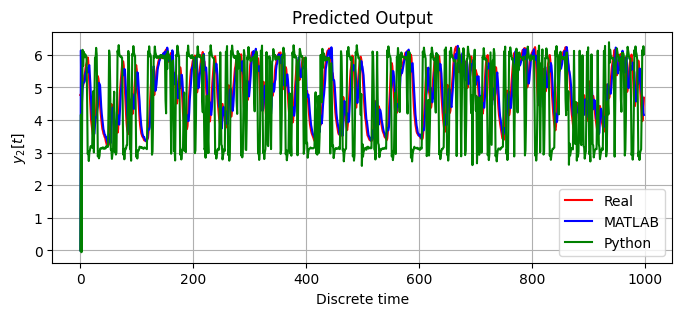

In [119]:
theta_MATLAB = [-1.286, 0.4017, 0.0008505, 0.005366, 0.06245, 0.04432]
# Choose one of the three final theta values
theta_Python = theta_CyCo

# Print Theta values
print(' > Theta < \n')

print(f'MATLAB = {theta_MATLAB}')
print(f'Python = {theta_Python}')

# Print Final Cost Function evaluations
print('\n > Cost Function <\n')
print(f'INITIAL Cost: {Ini_Cost}')

Cost_MATLAB = Cost(theta_MATLAB)
print(f'MATLAB = {Cost_MATLAB}')

Cost_Python = Cost(theta_Python)
print(f'Python = {Cost_Python}')

#Plot Predictions
MATLAB_Pred = Out_Model(theta_MATLAB, na, nb, input, output)
Python_Pred = Out_Model(theta_Python, na, nb, input, output)

#Figure
fig, ax = plt.subplots(figsize=(8, 3))

ax.plot(time, output, color='r', label='Real')
ax.plot(time, MATLAB_Pred, color='b', label='MATLAB')
ax.plot(time, Python_Pred, color='g', label='Python')
ax.set_title('Predicted Output')
ax.set_xlabel('Discrete time') 
ax.set_ylabel('$y_2[t]$') 
ax.grid(True)
ax.legend()